# Setup

In [1]:
import cv2
import os
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO


In [2]:
# Paths #
path_ann_train = "../dataset/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_train.json"
path_ann_val = "../dataset/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_val.json"
path_img_train = "../dataset/bdd100k_images_100k/bdd100k/images/100k/train"
path_img_val = "../dataset/bdd100k_images_100k/bdd100k/images/100k/val"

# YOLO Prediction vs Ground Truth

In [ ]:
# Setting Class Mappings
BDD_CLASS_MAP = {
        'person': 0,
        'bike': 1,
        'car': 2,
        'motor': 3, 
        'bus': 4,
        'train': 5, 
        'truck': 6,
        'traffic light': 7
    }

BDD_IND_TO_CLASS = {v: k for k, v in BDD_CLASS_MAP.items()}

YOLO_CLASS_MAP = {
        0: 'person',
        1: 'bike', # Originally bicycle
        2: 'car',
        3: 'motor', # Originally motorcycle
        5: 'bus',
        6: 'train', 
        7: 'truck',
        9: 'traffic light'
    }


image 1/1 c:\Users\prves\My_Data\03_Projects\2508_bdd100k_assignment\notebooks\..\dataset\bdd_yolo\images\val\c892a4e4-9bf183c0.jpg: 384x640 13 cars, 1 truck, 2 traffic lights, 255.3ms
Speed: 14.3ms preprocess, 255.3ms inference, 18.9ms postprocess per image at shape (1, 3, 384, 640)


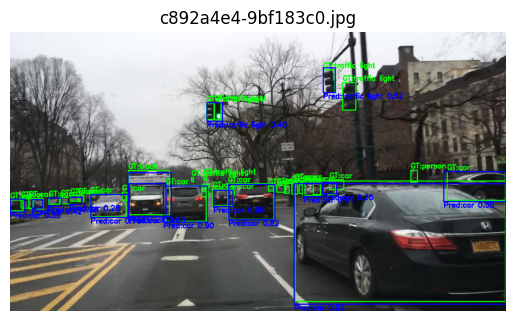

In [ ]:
def show_random_yolo_example(images_dir, labels_dir, model_path, class_names=None):
    # load YOLO model
    model = YOLO(model_path)

    # pick random image file
    img_file = random.choice([f for f in os.listdir(images_dir) if f.endswith((".jpg", ".png"))])
    label_file = os.path.splitext(img_file)[0] + ".txt"

    img_path = os.path.join(images_dir, img_file)
    label_path = os.path.join(labels_dir, label_file)

    # load image
    img = cv2.imread(img_path)
    h, w, _ = img.shape

    # ---------- Draw Ground Truth ----------
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())

            # denormalize
            x_center *= w
            y_center *= h
            width *= w
            height *= h

            x_min = int(x_center - width / 2)
            y_min = int(y_center - height / 2)
            x_max = int(x_center + width / 2)
            y_max = int(y_center + height / 2)

            # draw GT box in GREEN
            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            label = BDD_IND_TO_CLASS[int(class_id)]
            if class_names and int(class_id) < len(class_names):
                label = class_names[int(class_id)]
            cv2.putText(img, f"GT:{label}", (x_min, y_min - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # ---------- Draw YOLO Predictions ----------
    results = model(img_path, classes=list(YOLO_CLASS_MAP.keys()))[0]  # run inference
    for box in results.boxes:
        x_min, y_min, x_max, y_max = map(int, box.xyxy[0].cpu().numpy())
        conf = float(box.conf[0])
        class_id = int(box.cls[0])

        label = YOLO_CLASS_MAP[class_id]
        if class_names and class_id < len(class_names):
            label = class_names[class_id]

        # draw predicted box in RED
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        cv2.putText(img, f"Pred:{label} {conf:.2f}", (x_min, y_max + 15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # ---------- Show image ----------
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(img_file)
    plt.axis("off")
    plt.show()

# Example usage:
images_path = "../dataset/bdd_yolo/images/val"
labels_path = "../dataset/bdd_yolo/labels/val"
model_path = "yolov8n.pt"   # or your trained weights

show_random_yolo_example(images_path, labels_path, model_path)


# Evaluating YOLO on Validation Set

## YOLO 8n

In [5]:
model = YOLO("yolov8n.pt")

sub_classes = list(YOLO_CLASS_MAP.keys())
print(f"Only Testing on Following Classes {sub_classes}")

metrics = model.val(data="../dataset/bdd_yolo/bdd100k.yaml", classes=sub_classes)
metrics.results_dict

Only Testing on Following Classes [0, 1, 2, 3, 5, 6, 7, 9]
Ultralytics 8.3.179  Python-3.11.11 torch-2.7.1+cpu CPU (12th Gen Intel Core(TM) i5-1235U)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
val: Fast image access  (ping: 0.20.1 ms, read: 39.819.2 MB/s, size: 53.3 KB)


val: Scanning C:\Users\prves\My_Data\03_Projects\2508_bdd100k_assignment\dataset\bdd_yolo\labels\val.cache... 10000 images, 40 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]
c:\Users\prves\anaconda3\envs\ml_py311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 625/625 [13:32<00:00,  1.30s/it]


                   all      10000     148372      0.289      0.162      0.175     0.0903
                person       3220      13262      0.522      0.363      0.367      0.176
               bicycle        578       1007      0.503      0.157      0.188     0.0793
                   car       9879     102506      0.593      0.453      0.498      0.289
            motorcycle        334        452       0.31      0.157      0.138     0.0636
                   bus         14         15          0          0   4.15e-05   2.32e-05
                 train       2689       4245     0.0923    0.00565     0.0329     0.0241
                 truck       5653      26885          0          0   9.22e-05   3.39e-05
Speed: 0.6ms preprocess, 61.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\val9


{'metrics/precision(B)': np.float64(0.2886983943998391),
 'metrics/recall(B)': np.float64(0.1622246401598644),
 'metrics/mAP50(B)': np.float64(0.1747169341018001),
 'metrics/mAP50-95(B)': np.float64(0.09027668512562134),
 'fitness': np.float64(0.09872071002323922)}

In [ ]:

# Ultralytics 8.3.179  Python-3.11.11 torch-2.7.1+cpu CPU (12th Gen Intel Core(TM) i5-1235U)
# YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
# val: Fast image access  (ping: 0.00.0 ms, read: 683.2393.4 MB/s, size: 40.5 KB)
# val: Scanning C:\Users\prves\My_Data\03_Projects\2508_bdd100k_assignment\dataset\bdd_yolo\labels\val.cache... 10000 images, 40 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]
# c:\Users\prves\anaconda3\envs\ml_py311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
#   warnings.warn(warn_msg)
#                  Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 625/625 [13:20<00:00,  1.28s/it]
#                    all      10000     148372      0.289      0.162      0.175     0.0903
#                 person       3220      13262      0.522      0.363      0.367      0.176
#                bicycle        578       1007      0.503      0.157      0.188     0.0793
#                    car       9879     102506      0.593      0.453      0.498      0.289
#             motorcycle        334        452       0.31      0.157      0.138     0.0636
#                    bus         14         15          0          0   4.15e-05   2.32e-05
#                  train       2689       4245     0.0923    0.00565     0.0329     0.0241
#                  truck       5653      26885          0          0   9.22e-05   3.39e-05
# Speed: 0.6ms preprocess, 62.1ms inference, 0.0ms loss, 3.7ms postprocess per image
# Results saved to runs\detect\val6

# {'metrics/precision(B)': np.float64(0.2886983943998391),
#  'metrics/recall(B)': np.float64(0.1622246401598644),
#  'metrics/mAP50(B)': np.float64(0.1747169341018001),
#  'metrics/mAP50-95(B)': np.float64(0.09027668512562134),
#  'fitness': np.float64(0.09872071002323922)}

 

## YOLO 8m

In [ ]:
# Test the yolo Model #
model = YOLO("yolov8m.pt")

# Get predictions only on the subset on the classes it was trained on
metrics = model.val(data="../dataset/bdd_yolo/bdd100k.yaml", classes=list(YOLO_CLASS_MAP.keys()))
metrics.results_dict

Ultralytics 8.3.179  Python-3.11.11 torch-2.7.1+cpu CPU (12th Gen Intel Core(TM) i5-1235U)
YOLOv8m summary (fused): 92 layers, 25,886,080 parameters, 0 gradients, 78.9 GFLOPs
val: Fast image access  (ping: 0.20.1 ms, read: 78.060.7 MB/s, size: 60.3 KB)


val: Scanning C:\Users\prves\My_Data\03_Projects\2508_bdd100k_assignment\dataset\bdd_yolo\labels\val.cache... 10000 images, 40 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]
c:\Users\prves\anaconda3\envs\ml_py311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 625/625 [2:15:07<00:00, 12.97s/it]   


                   all      10000     148372      0.373      0.258      0.275      0.147
                person       3220      13262      0.667      0.491      0.527      0.263
               bicycle        578       1007      0.626       0.32       0.37      0.174
                   car       9879     102506      0.728      0.556      0.636      0.384
            motorcycle        334        452      0.494      0.372      0.355      0.182
                   bus         14         15   0.000561     0.0667   0.000218   0.000131
                 train       2689       4245     0.0965     0.0033     0.0348     0.0258
                 truck       5653      26885          0          0   0.000194   6.56e-05
Speed: 1.0ms preprocess, 786.0ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs\detect\val7


{'metrics/precision(B)': np.float64(0.37315346040647895),
 'metrics/recall(B)': np.float64(0.258406754551468),
 'metrics/mAP50(B)': np.float64(0.27478688509909965),
 'metrics/mAP50-95(B)': np.float64(0.14710078327414058),
 'fitness': np.float64(0.1598693934566365)}

In [ ]:
# Ultralytics 8.3.179  Python-3.11.11 torch-2.7.1+cpu CPU (12th Gen Intel Core(TM) i5-1235U)
# YOLOv8m summary (fused): 92 layers, 25,886,080 parameters, 0 gradients, 78.9 GFLOPs
# val: Fast image access  (ping: 0.20.1 ms, read: 78.060.7 MB/s, size: 60.3 KB)
# val: Scanning C:\Users\prves\My_Data\03_Projects\2508_bdd100k_assignment\dataset\bdd_yolo\labels\val.cache... 10000 images, 40 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]
# c:\Users\prves\anaconda3\envs\ml_py311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
#   warnings.warn(warn_msg)
#                  Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 625/625 [2:15:07<00:00, 12.97s/it]   
#                    all      10000     148372      0.373      0.258      0.275      0.147
#                 person       3220      13262      0.667      0.491      0.527      0.263
#                bicycle        578       1007      0.626       0.32       0.37      0.174
#                    car       9879     102506      0.728      0.556      0.636      0.384
#             motorcycle        334        452      0.494      0.372      0.355      0.182
#                    bus         14         15   0.000561     0.0667   0.000218   0.000131
#                  train       2689       4245     0.0965     0.0033     0.0348     0.0258
#                  truck       5653      26885          0          0   0.000194   6.56e-05
# Speed: 1.0ms preprocess, 786.0ms inference, 0.0ms loss, 2.7ms postprocess per image
# Results saved to runs\detect\val7
# {'metrics/precision(B)': np.float64(0.37315346040647895),
#  'metrics/recall(B)': np.float64(0.258406754551468),
#  'metrics/mAP50(B)': np.float64(0.27478688509909965),
#  'metrics/mAP50-95(B)': np.float64(0.14710078327414058),
#  'fitness': np.float64(0.1598693934566365)}

# Observations
1. Best Precision and Recall values for Car.
2. 2nd Best Precision and Recall values for Person.
3. 3rd best Precision and Recall values for Bicylce and 4th best is motorcycle.
4. Near zero scores on the rest of the classes.
5. Main cause of struggle is probably due to the shift in dataset. COCO to BDD
6. Because of the imbalance in the original COCO dataset. Model is relatively better at common classes like Person, Car, Bicycle.
7. Also. Yolo8n (3M parameters) is the smallest of all model. Therefore, drop in performance is expected.
8. Performance imporved significantly for top 4 classes after switching to a bigger model YOLO 8m (23M paramters). But for rest of the classes the performance remains remains almost the same.
